In [23]:
# kaggle titanic
# データ分割の検証
# 敬称の抽出・特徴量への追加
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
import warnings
# warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [24]:
# dataset
DATA_DIR = './data/'
TRAIN_DATA = 'train.csv'
TEST_DATA = 'test.csv'
SUBMIT_DATA = 'gender_submission.csv'

In [25]:
# load train data
RAW_DATA = pd.read_csv(os.path.join(DATA_DIR, TRAIN_DATA))

data_test = pd.read_csv(os.path.join(DATA_DIR, TEST_DATA)) 

data = RAW_DATA

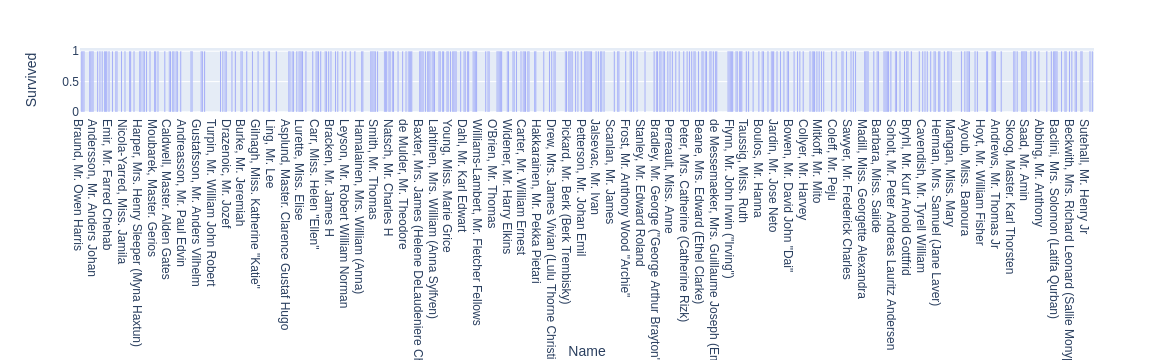

In [26]:
# 名前による分析
# plot
px.bar(data, x="Name", y="Survived")

In [27]:
#敬称(Honorific Title)の抽出
Title = data[["Survived", "Name"]]
Title["HonorificTitle"] = data["Name"].map(lambda x: x.split(', ')[1].split('. ')[0])

# 敬称の内容
Title["HonorificTitle"].value_counts()

# 少ない敬称はその他
Title["HonorificTitle"] = Title["HonorificTitle"].replace(["Dr", "Rev", "Major", "Col", "Mlle", "Jonkheer", "Ms", "Capt", "Mme", "Sir", "Don", "Lady", "the Countess"], "Others")
Title["HonorificTitle"].value_counts()

# 敬称別の生存率
Title["Survived"].groupby(Title["HonorificTitle"]).agg(["mean", "count"])

# 敬称毎に数字の割当
Title['HonorificTitle'] = Title['HonorificTitle'].map( {"Master": 0 , "Miss":1 , "Mr":2, "Mrs":3, "Others":4})
# Title.head()

# 敬称をHonorificTitleとして、データ・セットに追加
data['HonorificTitle'] = Title['HonorificTitle']

In [28]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HonorificTitle
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,4
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,2


In [29]:
# 欠損値処理、ダミー変数化
data['Fare'] = data['Fare'].fillna(np.mean(data['Fare']), inplace=True)

data.isnull().sum()

# Objective variable and Explanatory variable
y_1 = data['Survived']
# X_1 = data.drop(columns={'Survived', 'Name', 'Ticket', 'Embarked', 'Cabin'})
X_1 = data.drop(columns={'Survived', 'Name', 'Ticket', 'Cabin'})
# X_1 = data.drop(columns={'Survived', 'Ticket', 'Cabin'})
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X_1_le = X_1
Sex_le = le.fit_transform(X_1_le['Sex'])
X_1['Sex'] = Sex_le
embarked_le = le.fit_transform(X_1_le['Embarked'].values)
X_1['Embarked'] = embarked_le
# name_le = le.fit_transform(X_1_le['Name'].values)
# X_1['Name'] = name_le
X_1 = X_1.fillna(0)

In [30]:
#予測用ファイルの敬称(Honorific Title)の抽出
Title_test = data_test[["Name"]]
Title_test["HonorificTitle"] = data_test["Name"].map(lambda x: x.split(', ')[1].split('. ')[0])

# 敬称の内容
Title_test["HonorificTitle"].value_counts()

# 少ない敬称はその他
Title_test["HonorificTitle"] = Title_test["HonorificTitle"].replace(["Dr", "Rev", "Major", "Col", "Mlle", "Jonkheer", "Ms", "Capt", "Mme", "Sir", "Don", "Lady", "the Countess"], "Others")
Title_test["HonorificTitle"].value_counts()

# 敬称毎に数字の割当
Title_test['HonorificTitle'] = Title_test['HonorificTitle'].map( {"Master": 0 , "Miss":1 , "Mr":2, "Mrs":3, "Others":4})
# Title.head()

# 敬称をHonorificTitleとして、データ・セットに追加
data_test['HonorificTitle'] = Title_test['HonorificTitle']

In [31]:
# 予測用ファイルの欠損値処理
data_test['Fare'] = data_test['Fare'].fillna(np.mean(data_test['Fare']), inplace=True)

# Objective variable and Explanatory variable
# y_1 = data['Survived']
data_test = data_test.drop(columns={'Name', 'Ticket', 'Cabin'})
# data_test = data_test.drop(columns={'Ticket', 'Cabin'})
data_test_le = data_test

data_test_sex_le = le.fit_transform(data_test_le['Sex'])
data_test_le['Sex'] = data_test_sex_le

data_test_embarked_le = le.fit_transform(data_test_le['Embarked'])
data_test_le['Embarked'] = data_test_embarked_le

# data_test_name_le = le.fit_transform(data_test_le['Name'])
# data_test_le['Name'] = data_test_name_le

data_test_le = data_test_le.fillna(0)
data_predict = data_test_le

In [32]:
# X_train1, X_test1, y_train, y_test = train_test_split(X_1, y_1, random_state=0, test_size=0.3, stratify=y_1)
X_train1, X_test1, y_train, y_test = train_test_split(X_1, y_1, random_state=0, test_size=0.33, stratify=y_1)

In [33]:
X_train1.shape, y_train.shape, X_test1.shape, y_test.shape

((596, 9), (596,), (295, 9), (295,))

In [34]:
# GridSearchCV
# パラメータを dict 型で指定
# param_grid = {"eta": [0.3, 0.5, 0.7], "colsample_bytree":[0.5, 0.8], "subsample": [0.2, 0.7], "lambda": [0, 1],
#             "learning_rate":[0.05, 0.1, 0.3, 0.5]}
# param_grid = {"eta": [0.3, 0.5, 0.7], "colsample_bytree":[0.4, 0.7, 0.8], "subsample": [0.2, 0.7], "lambda": [0, 1],
#             "learning_rate":[0.03, 0.05, 0.1, 0.3, 0.5], "n_estimators": [80, 100, 150]}

param_grid = {"eta": [0.3, 0.5, 0.7], "colsample_bytree":[0.5, 0.8], "subsample": [0.2, 0.7], "lambda": [0, 1],
             "learning_rate":[0.05, 0.1, 0.3, 0.5], "n_estimators": [80, 100, 150]}           
             

# validation set は GridSearchCV が自動で作成してくれるため，
# training set と test set の分割のみを実行すればよい
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train1, y_train, random_state=0)

grid_search = GridSearchCV(xgb.XGBRFClassifier(), param_grid, cv=5)

# fit 関数を呼ぶことで交差検証とグリッドサーチがどちらも実行される
grid_search.fit(X_train2, y_train2)

print('Test set score: {}'.format(grid_search.score(X_test2, y_test2)))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross-validation: {}'.format(grid_search.best_score_))

[18:14:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:14:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:14:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:14:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [35]:
# GridSearchCVの結果をもとにXGBClassifierのパラーメータ指定
xgb_bst = xgb.XGBClassifier(objective="binary:logistic",
                            colsample_bytree=0.5,
                            eta=0.3,
                            # lambda= 0,
                            learning_rate=0.05,
                            subsample=0.7,
                            n_estimators=150,
                            eval_metric= 'logloss')                            

In [36]:
# 学習
# GridSearchCVで分割したデータを使う
# X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train1, y_train, random_state=0)
xgb_bst.fit(X_train2, y_train2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eta=0.3,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.7, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [37]:
data_predict.shape, X_train1.shape

((418, 9), (596, 9))

In [38]:
# xgb_bst.predict(data_predict)
xgb_bst_pred = xgb_bst.predict(data_predict)

In [39]:
# '''
# 交差検証
from sklearn.model_selection import cross_val_score

# xgbの分析結果比較
scores_01 = cross_val_score(xgb_bst ,X_train2, y_train2)
print('Cross-Validation scores: {}'.format(scores_01))

# スコアの平均値
import numpy as np
print('Average score: {}'.format(np.mean(scores_01)))
# '''

Cross-Validation scores: [0.77777778 0.8        0.82022472 0.80898876 0.83146067]
Average score: 0.8076903870162297


In [40]:
data_submit = pd.read_csv(os.path.join(DATA_DIR, SUBMIT_DATA))

In [41]:
# 提出用ファイルに予測結果を連結
# GrideSearchの結果を使った、モデリング結果を提出用ファイルに連結
data_submit['Survived'] = xgb_bst_pred

In [42]:
# write csv
data_submit.to_csv(os.path.join(DATA_DIR, 'submission_xgb16.csv'), index=False)

In [43]:
# xgb_bst.score(X_train2, y_train2)

0.9038031319910514

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

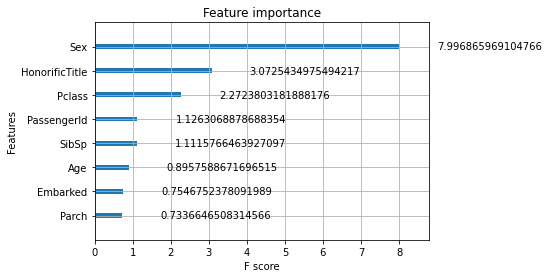

In [44]:
# feature importance
xgb.plot_importance(xgb_bst, show_values=True, importance_type='gain')